In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import itertools
import time

import torch, torchvision
from torchvision import transforms, datasets
import torch.nn.functional as F
from torch.utils import data
from torch import nn, optim

In [2]:
random_seed = 239
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
np.random.seed(random_seed)

In [3]:
class Normalize(object):
    """ Normalize tensor containing an image to [-1, 1] range. 
        It should be helpful since ReLU activation function is used.
        
        Note: this class is used instead of transforms.Normalize([0.5], [0.5]) for the sake of 
        practice with hand-written transformers.
    """
    
    def __call__(self, image):
        return image.sub_(0.5).mul_(2.)

In [4]:
datafolder = '~/FashionMNIST'
transform = transforms.Compose([
    transforms.ToTensor(), 
    Normalize()
    # transforms.Normalize([0.5], [0.5])
])
train_data = datasets.FashionMNIST(datafolder, train=True, download=True, transform=transform)
test_data = datasets.FashionMNIST(datafolder, train=False, download=True, transform=transform)

batch_size = 100
train_loader = data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')
n_classes = len(classes)

Number of training examples: 60000
Number of test examples: 10000


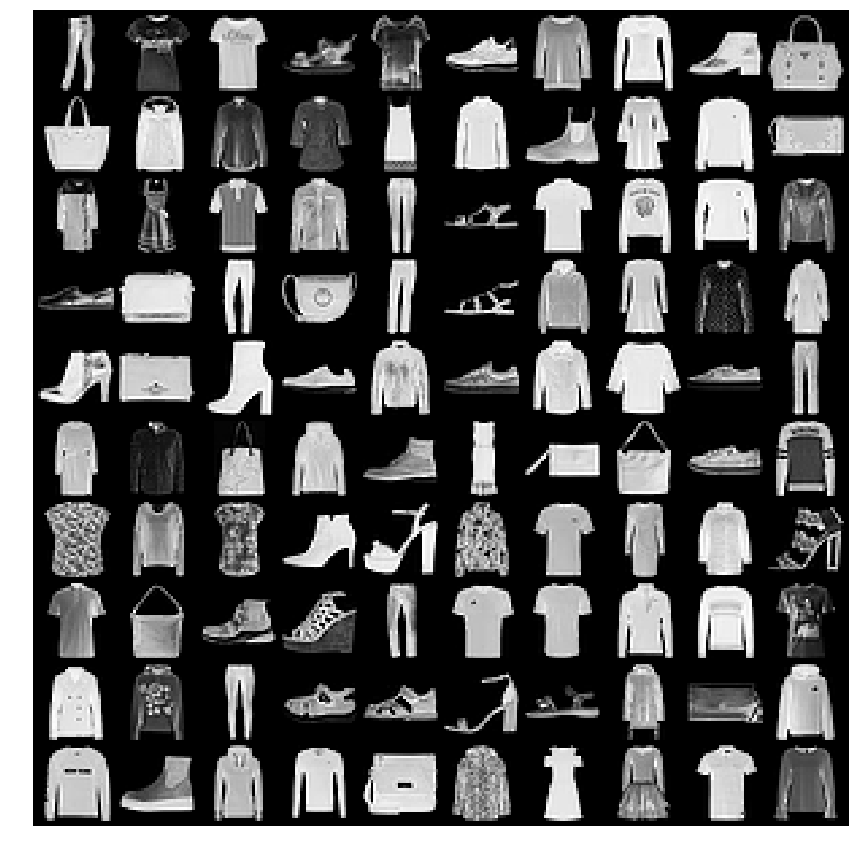

In [5]:
def imshow(img):
    img = torchvision.utils.make_grid(img, nrow=10, normalize=True, range=(-1., 1.))
    npimg = img.numpy()
    fig, ax = plt.subplots(figsize=(15, 15))
    plt.axis('off')
    ax.imshow(np.transpose(npimg, (1, 2, 0)), interpolation='nearest')

print("Number of training examples: {}".format(len(train_data)))
print("Number of test examples: {}".format(len(test_data)))

dataiter = iter(train_loader)
images, labels = dataiter.next()
imshow(images)

In [8]:
class BasicCNN(torch.nn.Module):
    
    def __init__(self, input_dim=28, output_dim=10):
        """ Basic CNN architecture:
            Activation function is ReLU for each layer.
            Two convolution layers with max-pooling.
            Two fully-connected layers to get the answer.
        """
        super(BasicCNN, self).__init__()
        kernel = 5
        out_dim = 3
        hidden_layer = 32
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=out_dim, kernel_size=kernel, padding=(kernel - 1) // 2)
        self.maxpool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(in_channels=out_dim, out_channels=out_dim ** 2, kernel_size=kernel, padding=(kernel - 1) // 2)
        self.maxpool2 = nn.MaxPool2d(2)
        self.linear1 = nn.Linear((input_dim // 4) * (input_dim // 4) * (out_dim ** 2), hidden_layer)
        self.linear2 = nn.Linear(hidden_layer, output_dim)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.maxpool1(x)
        x = F.relu(self.conv2(x))
        x = self.maxpool2(x)
        x = x.view(-1, x[0].numel())
        x = F.relu(self.linear1(x))
        x = F.log_softmax(self.linear2(x), dim=1)
        return x
        
net = BasicCNN()

Epoch #1 took 24s
Train loss = 0.528
Test loss = 0.553


Epoch #2 took 21s
Train loss = 0.419
Test loss = 0.442


Epoch #3 took 24s
Train loss = 0.381
Test loss = 0.405


Epoch #4 took 22s
Train loss = 0.363
Test loss = 0.391


Epoch #5 took 23s
Train loss = 0.337
Test loss = 0.368


Epoch #6 took 23s
Train loss = 0.331
Test loss = 0.362


Epoch #7 took 24s
Train loss = 0.308
Test loss = 0.345


Epoch #8 took 20s
Train loss = 0.298
Test loss = 0.336


Epoch #9 took 20s
Train loss = 0.284
Test loss = 0.325


Epoch #10 took 25s
Train loss = 0.287
Test loss = 0.328


Epoch #11 took 22s
Train loss = 0.273
Test loss = 0.317


Epoch #12 took 23s
Train loss = 0.269
Test loss = 0.315


Epoch #13 took 23s
Train loss = 0.272
Test loss = 0.317


Epoch #14 took 22s
Train loss = 0.255
Test loss = 0.306


Epoch #15 took 22s
Train loss = 0.249
Test loss = 0.299


Epoch #16 took 25s
Train loss = 0.247
Test loss = 0.300


Epoch #17 took 23s
Train loss = 0.244
Test loss = 0.296


Epoch #18 took 22s
Train loss = 0.236
Test loss = 0.294


Epoch #19 took 21s
Train loss = 0.231
Test loss = 0.286


Epoch #20 took 20s
Train loss = 0.228
Test loss = 0.287


Epoch #21 took 20s
Train loss = 0.225
Test loss = 0.289


Epoch #22 took 20s
Train loss = 0.225
Test loss = 0.292


Epoch #23 took 20s
Train loss = 0.223
Test loss = 0.291


Epoch #24 took 20s
Train loss = 0.220
Test loss = 0.287


Epoch #25 took 20s
Train loss = 0.213
Test loss = 0.284


Epoch #26 took 20s
Train loss = 0.205
Test loss = 0.280


Epoch #27 took 20s
Train loss = 0.203
Test loss = 0.283


Epoch #28 took 20s
Train loss = 0.210
Test loss = 0.290


Epoch #29 took 20s
Train loss = 0.204
Test loss = 0.282


Epoch #30 took 21s
Train loss = 0.201
Test loss = 0.286

Training took 665s


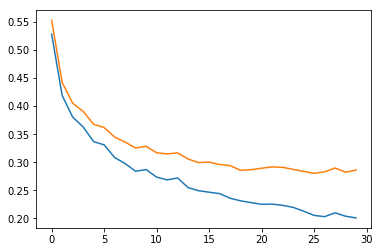

In [9]:
def total_loss(model, loader, criterion):
    with torch.no_grad():
        total = 0
        for in_batch, out_batch in loader:
            total += criterion(model(in_batch), out_batch).item()
    return total / len(loader)

def train_model(model, optimizer, criterion):
    train_loss = []
    test_loss = []
    start_time = time.time()
    for epoch in range(1, epochs + 1):
        epoch_start_time = time.time()
        for in_batch, out_batch in train_loader:
            out_pred = model(in_batch)
            loss = criterion(out_pred, out_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
      
        train_loss.append(total_loss(model, train_loader, criterion))
        test_loss.append(total_loss(model, test_loader, criterion))
        print("Epoch #{} took {}s".format(epoch, int(time.time() - epoch_start_time)))
        print("Train loss = {:.3f}".format(train_loss[-1]))
        print("Test loss = {:.3f}".format(test_loss[-1]))
        
    print("\nTraining took {}s".format(int(time.time() - start_time)))
    plt.plot(train_loss, label='Train loss')
    plt.plot(test_loss, label='Test loss')
    plt.show()

epochs = 30
learning_rate = 0.001

# Adam has shown better results than SGD.
train_model(net, optim.Adam(net.parameters(), lr=learning_rate), nn.CrossEntropyLoss())
# train_model(net,  optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9), nn.CrossEntropyLoss())

Predicted:  Ankle boot, Trouser, Sneaker,   Bag,  Coat, Dress, Ankle boot,  Coat, Sneaker, T-shirt/top
GroundTruth:  Ankle boot, Trouser, Sneaker,   Bag,  Coat, Dress, Sandal,  Coat, Sneaker, T-shirt/top


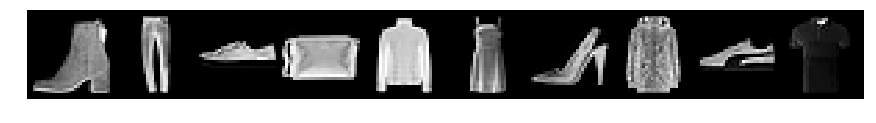

In [10]:
test_size = 10

dataiter = iter(test_loader)
images, labels = dataiter.next()
images = images[:test_size]
labels = labels[:test_size]

imshow(images)
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ', '.join('%5s' % classes[predicted[j]] for j in range(test_size)))
print('GroundTruth: ', ', '.join('%5s' % classes[labels[j]] for j in range(test_size)))

In [11]:
# Compute overall accuracy

correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the {} test images: {:.2%}'.format(len(test_data), correct / total))

Accuracy of the network on the 10000 test images: 89.73%


In [13]:
# Compute accuracy for each class

class_correct = [0.] * n_classes
class_total = [0.] * n_classes
with torch.no_grad():
    for images, labels in test_loader:
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(n_classes):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(n_classes):
    print('Accuracy of {:<13} : {:.2%}'.format(classes[i], class_correct[i] / class_total[i]))

Accuracy of T-shirt/top   : 79.81%
Accuracy of Trouser       : 95.83%
Accuracy of Pullover      : 92.22%
Accuracy of Dress         : 91.07%
Accuracy of Coat          : 78.95%
Accuracy of Sandal        : 97.89%
Accuracy of Shirt         : 74.12%
Accuracy of Sneaker       : 97.67%
Accuracy of Bag           : 98.89%
Accuracy of Ankle boot    : 94.23%


In [73]:
# Compute accuracy for each class
def pretty_print(matrix):
    s = [[str(e) for e in row] for row in matrix]
    lens = [max(map(lambda t: len(t) + 8, col)) for col in zip(*s)]
    fmt = '\t'.join('{{:<{}}}'.format(x) for x in lens)
    table = [fmt.format(*row) for row in s]
    print('\n'.join(table))

confusion_matrix = [[0] * n_classes for _ in range(n_classes)]
with torch.no_grad():
    for images, labels in test_loader:
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        for prediction, label in zip(predicted, labels):
            confusion_matrix[label.item()][prediction.item()] += 1
pretty_print(confusion_matrix)


844        	2          	31         	25         	3          	4          	76         	0          	15         	0          
2          	964        	1          	20         	7          	1          	3          	0          	2          	0          
13         	1          	781        	10         	104        	0          	86         	0          	5          	0          
50         	16         	11         	816        	33         	1          	67         	0          	6          	0          
2          	1          	103        	31         	726        	0          	132        	0          	5          	0          
0          	0          	0          	1          	0          	933        	0          	51         	2          	13         
187        	2          	112        	21         	74         	1          	579        	0          	24         	0          
0          	0          	0          	0          	0          	20         	0          	966        	0          	14         
1          	2          	8          	5   